In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

start = "2025-01-01"
end = "2025-11-21"
interval = "1d"
cvx = yf.Ticker("CVX").history(start=start, end=end, interval=interval)['Close']
bkr = yf.Ticker("BKR").history(start=start, end=end, interval=interval)['Close']

cvx_mean = cvx.mean()
bkr_mean = bkr.mean()

cvx_std = np.std(cvx)
bkr_std = np.std(bkr)
# build combined df
df = pd.concat([cvx.rename('cvx'), bkr.rename('bkr')], axis=1).dropna()

# normalize data
df['cvx'] = (df['cvx']-cvx_mean)/cvx_std
df['bkr'] = (df['bkr']-bkr_mean)/bkr_std
print(df)

                                cvx       bkr
Date                                         
2025-01-02 00:00:00-05:00 -0.891372 -0.453697
2025-01-03 00:00:00-05:00 -0.759184 -0.194457
2025-01-06 00:00:00-05:00 -0.827601 -0.154392
2025-01-07 00:00:00-05:00 -0.557427 -0.020058
2025-01-08 00:00:00-05:00 -0.475096 -0.010632
...                             ...       ...
2025-11-14 00:00:00-05:00  1.009713  1.481588
2025-11-17 00:00:00-05:00  0.673743  1.276984
2025-11-18 00:00:00-05:00  0.735620  1.320312
2025-11-19 00:00:00-05:00  0.502668  1.421411
2025-11-20 00:00:00-05:00  0.334020  1.322719

[223 rows x 2 columns]


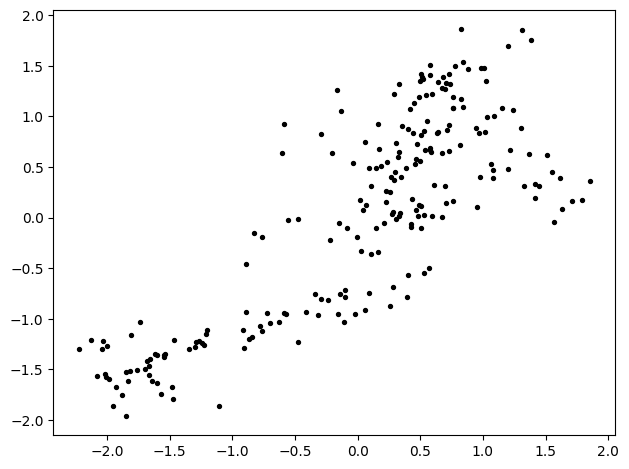

In [3]:
cvx = df['cvx'].to_numpy()
bkr = df['bkr'].to_numpy()

plt.scatter(x=cvx, y=bkr, color='black', s=8)
plt.tight_layout()
plt.show()

Creating function $f: \mathbb{R^2} \to \mathbb{R}$ defined by,

$$
f(X) = f((x_1, x_2)) = \frac{1}{2}(x_1 + x_2),
$$

to bring points $X_1, ..., X_n$ to $\mathbb{R^1}$.


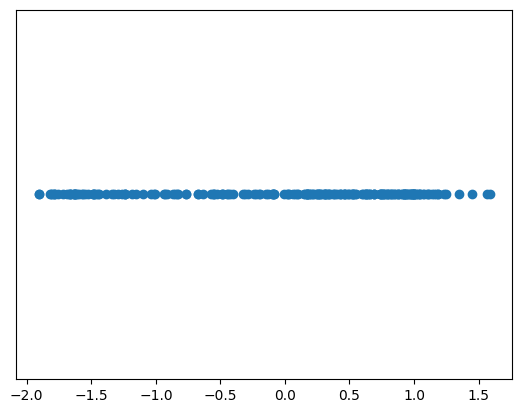

In [4]:
def f(x1, x2):
    return (1/2)*(x1+x2)

fx = []
for i in range(len(cvx)):
    fx.append(f(cvx[i], bkr[i]))

plt.scatter(fx, [0]*len(fx))
plt.yticks([])       # remove Y axis
plt.ylim(-1, 1)      # optional padding
plt.show()

Now that we have projected our values $(c_i, b_i)$ onto $\mathbb{R}$, we can create covers $U_1, ..., U_n$, or equivalently in $\mathbb{R}$, intervals $I_1, ..., I_n$ such that:

$$
[\min{f(X)}, \max{f(X)}] = \bigcup_i I_i.
$$

We will do this using methods of the Mapper algorithm. We choose a number of covers $N$ and a percentage of overlap $\alpha$ to construct the width $w$ of each cover $I_i$. The width of each cover will be:

$$
w = \frac{\max f(X) - \min f(X)}{N-(N-1)\alpha}.
$$

As our step, we will use $s=w(1-\alpha)$. Iteratively, we build covers $I_1, ..., I_N$:

* $I_1 = [\min f(X) + 0s, \min f(X) + w]$
* $I_2 = [\min f(X) + 1s, (\min f(X) + 1s) + w]$
* $...$
* $I_N = [\min f(X) + (N-1)s, (\min f(X) + (N-1s)) + w]$

We will build a function that builds and returns $N$ covers (intervals) with $\alpha$ overlap given a general interval $[x_0, x_1]$.


In [5]:
from typing import List, Tuple
from numbers import Real

def get_covers(xmin: float, xmax: float, N_covers: int, overlap: float) -> List[Tuple[Real, Real]]:
    width = (xmax-xmin)/(N_covers - ((N_covers - 1)*overlap))
    step = width*(1-overlap)
    
    intervals = []
    for i in range(N_covers):
        l = xmin + i*step
        u = l + width 
        intervals.append((l, u))
    
    return intervals
    
# try function on our projected data fx
# use N=3 covers and overlap of 40%
intervals = get_covers(xmin=min(fx), xmax=max(fx), N_covers=3, overlap=0.4)
print(intervals)

[(np.float64(-1.9080370765434533), np.float64(-0.3204188001479138)), (np.float64(-0.9554661107061296), np.float64(0.6321521656894099)), (np.float64(-0.0028951448688059322), np.float64(1.5847231315267336))]


Now that we have our interval covers, we can begin classifying our points $f(X) \in \mathbb{R}$. For a clear understanding of which points belong to which cover, we will use a data frame object.

In [6]:
def in_interval(value: float, interval: Tuple[float, float]) -> bool:
    return (value>= interval[0] and value<= interval[1])

def belongs_to_covers(value: float, cover: List[Tuple[float, float]]) -> List[int]:
    belongs_to = []
    for i in range(len(cover)):
        if in_interval(value=value, interval=cover[i]):
            belongs_to.append(i)
    return belongs_to



interval_info = pd.DataFrame({"f(X)": fx})
interval_info["cover"] = interval_info['f(X)'].apply(lambda v: belongs_to_covers(v, intervals))
print(interval_info)

         f(X)   cover
0   -0.672535  [0, 1]
1   -0.476821  [0, 1]
2   -0.490996  [0, 1]
3   -0.288743     [1]
4   -0.242864     [1]
..        ...     ...
218  1.245651     [2]
219  0.975363     [2]
220  1.027966     [2]
221  0.962039     [2]
222  0.828369     [2]

[223 rows x 2 columns]


Let us now color in the values $f(X)$ based on the cover they belong to. If they belong to more than one cover we will color them based on a determined intersection color.

         f(X)   cover
0   -0.672535  [0, 1]
1   -0.476821  [0, 1]
2   -0.490996  [0, 1]
3   -0.288743     [1]
4   -0.242864     [1]
..        ...     ...
218  1.245651     [2]
219  0.975363     [2]
220  1.027966     [2]
221  0.962039     [2]
222  0.828369     [2]

[223 rows x 2 columns]


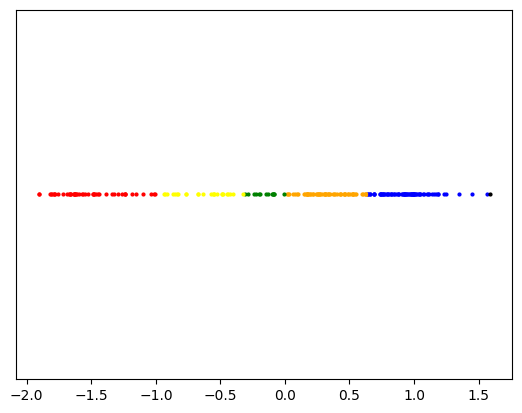

In [7]:
colors = {(0, ): "red", 
          (0, 1): "yellow", 
          (1, ): "green",
          (1, 2): "orange",
          (2, ): "blue"}

def get_class_color(covers: List[int]) -> str:
    if covers==[0]:
        return "red"
    if covers==[0,1]:
        return "yellow"
    if covers==[1]:
        return "green"
    if covers==[1,2]:
        return "orange"
    if covers==[2]:
        return "blue"
    else:
        return "black"

print(interval_info)
for i in range(len(interval_info)):
    plt.scatter(x=interval_info['f(X)'].iloc[i], y=1, color=get_class_color(covers=interval_info['cover'].iloc[i]) ,s=4)

plt.yticks([])
plt.show()


Above are our points from list $\text{fx}$ where each $\text{fx}_i$ corresponds to the value $f(c_i, b_i)$ for $c$ and $b$ our series $\text{CVX, BKR}$ respectively. We will rebuild our original scatter plot, using the above cover classification. Read code for color/cover mappings.

Each point $(c_i, b_i)$ in our classified scatter plot belongs to cover $k$ if $f(c_i, b_i) \in U_k$. Again, points that belong to multiple covers are given a mixed color class.

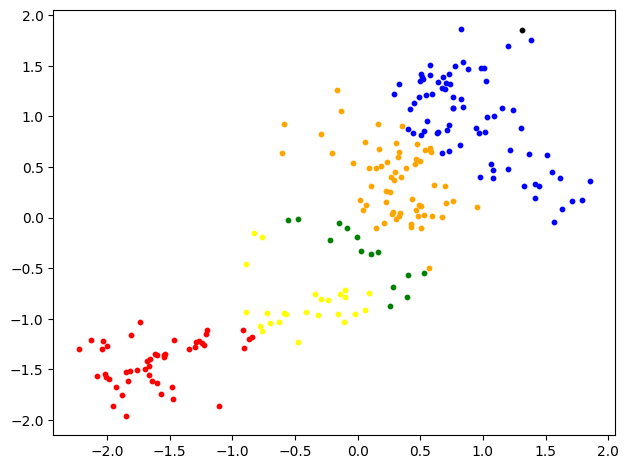

In [8]:
for i in range(len(interval_info)):
    plt.scatter(x=cvx[i], y=bkr[i], color=get_class_color(covers=interval_info['cover'].iloc[i]), s=10)

plt.tight_layout()
plt.show()

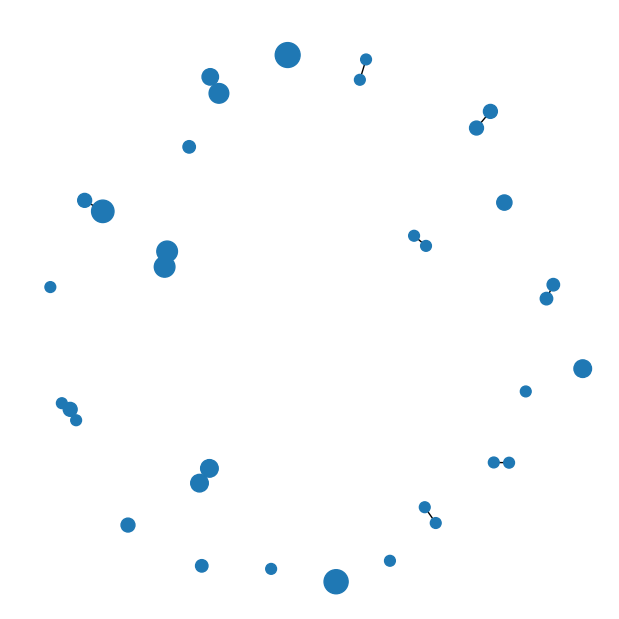

In [10]:
from sklearn.cluster import DBSCAN
import networkx as nx

points = np.column_stack([cvx, bkr])

def build_mapper_graph(X: np.ndarray,
                       fvals: np.ndarray,
                       intervals: List[List],
                       clusterer=None):
    '''
    Build a Mapper graph from data, filter values, and a 1D cover. Returns graph G along with node information.
    '''
    # --- NEW: force numpy arrays ---
    X = np.asarray(X, dtype=float)
    fvals = np.asarray(fvals, dtype=float).reshape(-1)

    if clusterer is None:
        # Default clusterer: DBSCAN (good for arbitrary shapes)
        clusterer = DBSCAN(eps=0.1, min_samples=3)

    n, d = X.shape
    G = nx.Graph()
    node_info = {}
    point_to_nodes = {i: [] for i in range(n)}  # which nodes contain point i

    node_id = 0

    # --- 1. For each interval, cluster its points ---
    for cover_id, (a, b) in enumerate(intervals):
        # Indices of points in this cover element
        in_cover = np.where((fvals >= a) & (fvals <= b))[0]
        if len(in_cover) == 0:
            continue

        X_cover = X[in_cover]

        # Cluster within this cover
        labels = clusterer.fit_predict(X_cover)

        # For each cluster label (ignoring noise = -1)
        unique_labels = [lab for lab in np.unique(labels) if lab != -1]

        for lab in unique_labels:
            mask = (labels == lab)
            cover_indices = in_cover[mask]  # original point indices

            if len(cover_indices) == 0:
                continue

            # Add a node for this cluster
            G.add_node(node_id)
            node_info[node_id] = {
                "cover_id": cover_id,
                "cluster_label": int(lab),
                "points": set(cover_indices),
                "size": len(cover_indices),
                "mean_filter": float(fvals[cover_indices].mean()),
            }

            # Record membership: which nodes each point belongs to
            for idx in cover_indices:
                point_to_nodes[idx].append(node_id)

            node_id += 1

    # --- 2. Add edges between nodes that share points ---
    # For each point, connect all nodes that contain it
    for idx, nodes in point_to_nodes.items():
        if len(nodes) <= 1:
            continue
        # all unordered pairs of nodes
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                u, v = nodes[i], nodes[j]
                if G.has_edge(u, v):
                    continue
                G.add_edge(u, v)

    return G, node_info


G, node_info = build_mapper_graph(X = points, fvals=fx, intervals=intervals)

sizes = [node_info[n]["size"] * 20 for n in G.nodes]  # bigger node = bigger cluster

pos = nx.spring_layout(G, seed=0)
plt.figure(figsize=(6, 6))
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=sizes
)
plt.show()
